In [2]:
pip install qiskit

     |████████████████████████████████| 2.7MB 9.7MB/s 
     |████████████████████████████████| 18.2MB 133kB/s 
     |████████████████████████████████| 92kB 7.6MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 983kB 45.1MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 5.6MB 48.3MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 573kB 45.9MB/s 
     |████████████████████████████████| 21.7MB 109kB/s 
     |████████████████████████████████| 2.3MB 41.5MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
  Created wheel for qiskit: filename=qiskit-0.14.0-cp36-none-any.whl size=1400 sha256=666456a75ebeb7d07f27e841f37bc8258695893181ffb50c75361743e59779d3
  Stored in directory: /root/.cache/pip/wheels/78/56/d2/194c8ea4c20e67c474027da

In [0]:
from qiskit import Aer
from qiskit.aqua.components.oracles import LogicalExpressionOracle
from qiskit.aqua.algorithms import Grover

sat_cnf = """
c Example DIMACS 3-Sat
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 3 0
1 -2 -3 0
-1 2 3 0
"""
simulator = Aer.get_backend("qasm_simulator")
oracle = LogicalExpressionOracle(sat_cnf)
algorithm = Grover(oracle)
result = algorithm.run(simulator)
print(result["result"])

[-1, -2, 3]


In [0]:
from qiskit import Aer,execute,QuantumCircuit,BasicAer,ClassicalRegister,QuantumRegister
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



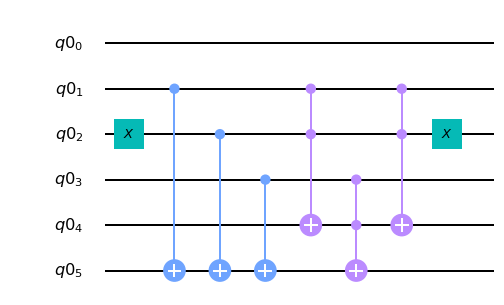

In [4]:
q = QuantumRegister(6)
qc = QuantumCircuit(q)
qc.x(q[2])
qc.cx(q[1],q[5])
qc.cx(q[2],q[5])
qc.cx(q[3],q[5])
qc.ccx(q[1], q[2], q[4])
qc.ccx(q[3], q[4], q[5])
qc.ccx(q[1], q[2], q[4])
qc.x(q[2])
qc.draw(output="mpl")

In [0]:
def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
    """Circuit that computes the black-box function from f_in to f_out.

    Create a circuit that verifies whether a given exactly-1 3-SAT
    formula is satisfied by the input. The exactly-1 version
    requires exactly one literal out of every clause to be satisfied.
    """
    num_clauses = len(exactly_1_3_sat_formula)
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
# -- end function

In [0]:

def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
# -- end function

In [0]:
def inversion_about_average(circuit, f_in, n):
    """Apply inversion about the average step of Grover's algorithm."""
    # Hadamards everywhere
    for j in range(n):
        circuit.h(f_in[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h(f_in[j])
# -- end function

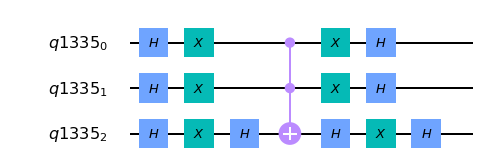

In [65]:

qr = QuantumRegister(3)
qInvAvg = QuantumCircuit(qr)
inversion_about_average(qInvAvg, qr, 3)
qInvAvg.draw(output='mpl')

In [68]:
"""
Grover search implemented in Qiskit.

This module contains the code necessary to run Grover search on 3
qubits, both with a simulator and with a real quantum computing
device. This code is the companion for the paper
"An introduction to quantum computing, without the physics",
Giacomo Nannicini, https://arxiv.org/abs/1708.03684. 
"""

def input_state(circuit, f_in, f_out, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)
# -- end function

# Make a quantum program for the n-bit Grover search.
n = 3

# Exactly-1 3-SAT formula to be satisfied, in conjunctive
# normal form. We represent literals with integers, positive or
# negative, to indicate a Boolean variable or its negation.
exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

# Define three quantum registers: 'f_in' is the search space (input
# to the function f), 'f_out' is bit used for the output of function
# f, aux are the auxiliary bits used by f to perform its
# computation.
f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)

# Define classical register for algorithm result
ans = ClassicalRegister(n)

# Define quantum circuit with above registers
grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)
grover.add_register(ans)

#grover.draw(output='mpl')
input_state(grover, f_in, f_out, n)
T = 2
for t in range(T):
    # Apply T full iterations
    black_box_u_f(grover, f_in, f_out, aux, n, exactly_1_3_sat_formula)
    inversion_about_average(grover, f_in, n)

# Measure the output register in the computational basis
for j in range(n):
    grover.measure(f_in[j], ans[j])

#grover.draw(output='mpl')
# Execute circuit
backend = BasicAer.get_backend('qasm_simulator')
job = execute([grover], backend=backend, shots=1000)
result = job.result()

# Get counts and plot histogram
counts = result.get_counts(grover)
plot_histogram(counts)



BrokenProcessPool: ignored

Credentials are already in use. The existing account in the session will be replaced.


gates =  OrderedDict([('ccx', 44), ('x', 37), ('cx', 36), ('h', 20), ('measure', 3)])
depth =  85


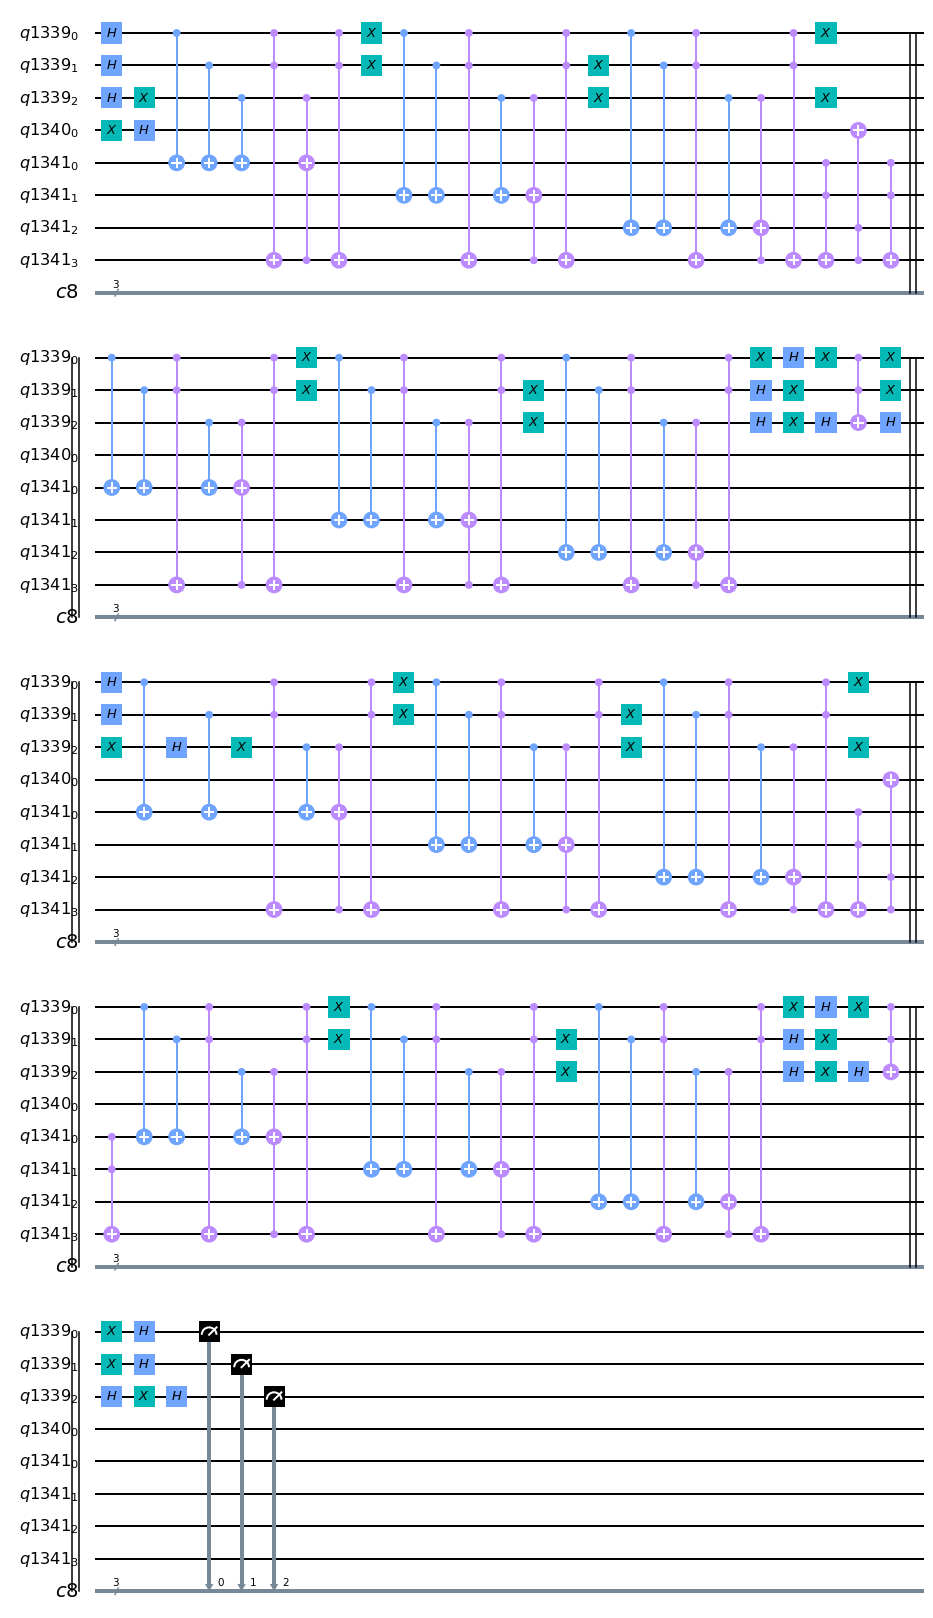

In [69]:
from qiskit import IBMQ
from qiskit.tools.monitor import backend_overview
IBMQ.save_account(token='0cd03ddc894cbb0be78b84b94f76b25cbda84c6e281b23285c606fc7ca9b96ee5a012cd30117adc4e2d08e7f3247e47bb4f54983720f51b51183461f81f5d9b0',overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
#backend_overview() # Function to get all information back about each device  

#print('\nPress any key to close')
#input()
grover_compiled = transpile(grover, backend=provider.get_backend('ibmq_qasm_simulator'), seed_transpiler=1, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())
#print ('count = ' , grover_compiled.result().get_counts())
grover_compiled.draw(output='mpl', scale=0.5)


In [0]:
# Get counts and plot histogram


